## Partie 3 : Dérivation Numérique
Dans cette section, nous utilisons des méthodes de dérivation numérique pour analyser divers indicateurs épidémiologiques.

In [108]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Importation des modules internes du projet
from src.analysis import estimer_parametres_rab
from src.analysis.derivation.methodes import Derivation
from src.data import DataPipeline

In [109]:
# Chargement des données France
pipeline_fr = DataPipeline(country="France")
df_fr = pipeline_fr.run()
parametres_fr = estimer_parametres_rab(df_fr)

# Chargement des données Italie
pipeline_ma = DataPipeline(country="Morocco")
df_ma = pipeline_ma.run()

### Question a) Estimation du taux de transmission (r)
**Objectif** : Calculer le paramètre épidémiologique clé à partir des données observées  
**Méthode** :  
- Utilisation de la formule dérivée du modèle SIRD :  
$$ r = \frac{\frac{dI}{dt} + (a + b)I}{SI} $$  
- Filtrage des valeurs aberrantes et calcul de la médiane

In [110]:
a = parametres_fr["a"]  # Taux de guérison estimé
b = parametres_fr["b"]   # Taux de mortalité estimé

# Calcul des composantes de la formule
df_fr['numerateur'] = df_fr['dI_dt'] + (a + b)*df_fr['I']
df_fr['denominateur'] = df_fr['S']*df_fr['I']

# Filtrage des valeurs valides
condition_valide = (df_fr['denominateur'] > 1e-6) & (df_fr['I'] > 1e-4)
r_estimations = df_fr[condition_valide]['numerateur']/df_fr[condition_valide]['denominateur']

# Statistiques robustes
r_median = np.nanmedian(r_estimations)
r_moyen = np.nanmean(r_estimations)

print(f"Estimation du taux de transmission :")
print(f"- Médiane : {r_median:.4f}")
print(f"- Moyenne : {r_moyen:.4f}")

Estimation du taux de transmission :
- Médiane : 0.0983
- Moyenne : 0.1027


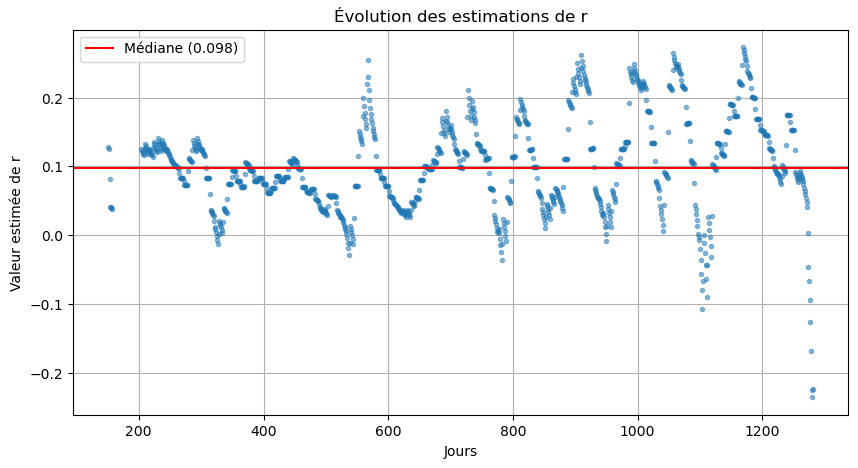

In [111]:
# Visualisation des estimations
plt.figure(figsize=(10, 5))
plt.plot(r_estimations.index, r_estimations.values, '.', alpha=0.5)
plt.axhline(r_median, color='r', label=f'Médiane ({r_median:.3f})')
plt.title('Évolution des estimations de r')
plt.ylabel('Valeur estimée de r')
plt.xlabel('Jours')
plt.legend()
plt.grid(True)
plt.show()

### Question b) Détermination du taux de croissance initial
**Objectif** : Quantifier la croissance exponentielle en phase précoce  
**Méthode** :  
- Calcul du taux de croissance relatif journalier :  
$$ r_c = \frac{I(t+\Delta t) - I(t)}{\Delta t \cdot I(t)} $$  
- Moyennage sur la période où S ≈ 1 (population entièrement sensible)

### Question c) Identification du pic épidémique
**Objectif** : Déterminer le moment où l'épidémie commence à décroître  
**Méthode** :  
- Calcul de la dérivée numérique de I(t) via la méthode des différences finies à 5 points  
- Recherche du premier instant où $\frac{dI}{dt} < 0$  

In [112]:
# Calcul de la dérivée première des infectés
derivee_I = Derivation(df=df_fr, col="I", h=1)
df_fr["dI_dt"] = derivee_I.premier_derivation_5point()

# Identification du changement de signe
point_inflexion = df_fr[df_fr['dI_dt'] < 0]

if not point_inflexion.empty:
    tc = point_inflexion.iloc[0]['date']
    print(f"Le pic épidémique survient autour de {tc}")
else:
    print("Aucun pic détecté dans l'intervalle étudié.")

Le pic épidémique survient autour de 2020-01-24 00:00:00


### Question d) Comparaison régionale
**Objectif** : Analyser les différences de propagation entre France et Italie  
**Méthode** :  
- Calcul des dérivées $\frac{dI}{dt}$ pour les deux pays  
- Comparaison visuelle des courbes et des pics épidémiques  

In [113]:
# Calcul des dérivées pour les deux pays
df_fr["dI_dt"] = Derivation(df=df_fr, col="I", h=1).premier_derivation_5point()
df_ma["dI_dt"] = Derivation(df=df_ma, col="I", h=1).premier_derivation_5point()

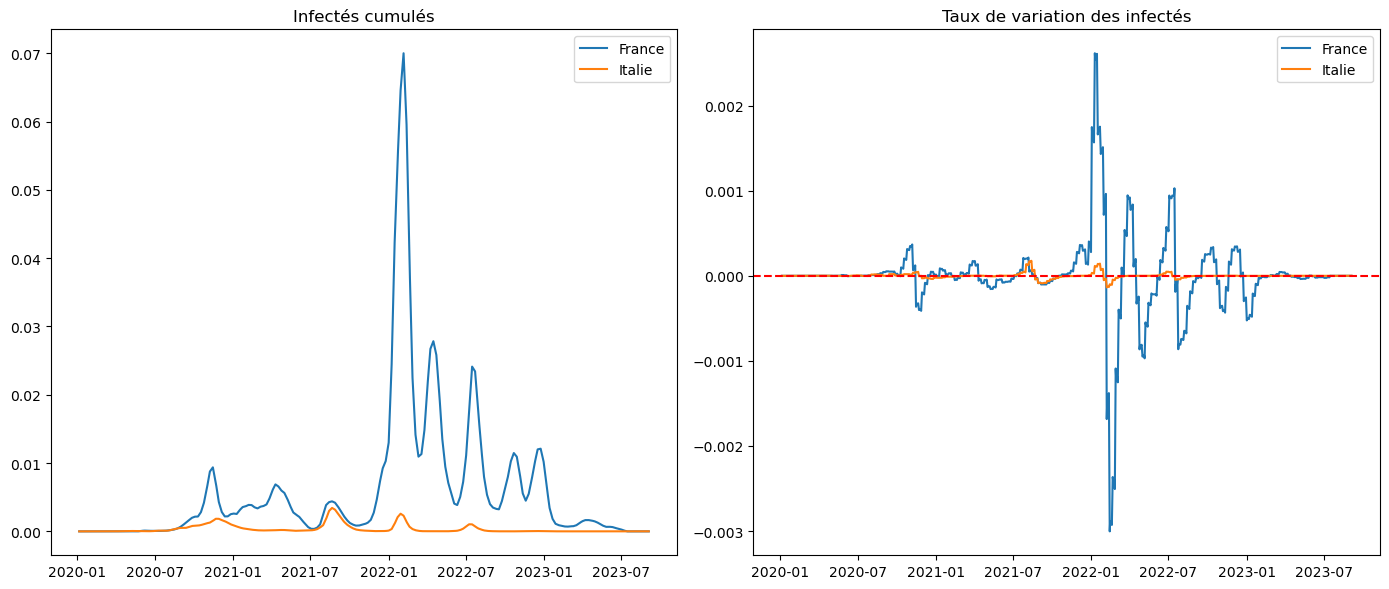

In [114]:
# Visualisation comparative
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df_fr['date'], df_fr['I'], label='France')
plt.plot(df_ma['date'], df_ma['I'], label='Italie')
plt.title('Infectés cumulés')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_fr['date'], df_fr['dI_dt'], label='France')
plt.plot(df_ma['date'], df_ma['dI_dt'], label='Italie')
plt.axhline(0, color='r', linestyle='--')
plt.title('Taux de variation des infectés')
plt.legend()
plt.tight_layout()
plt.show()

### Question e) Dynamique des compartiments S et R
**Objectif** : Étudier l'évolution des populations sensibles et guéries  
**Méthode** :  
- Calcul des dérivées $\frac{dS}{dt}$ et $\frac{dR}{dt}$  
- Analyse de leur corrélation avec les mesures de confinement  

In [115]:
# Calcul des dérivées
df_fr["dS_dt"] = Derivation(df=df_fr, col="S", h=1).premier_derivation_5point()
df_fr["dR_dt"] = Derivation(df=df_fr, col="R", h=1).premier_derivation_5point()

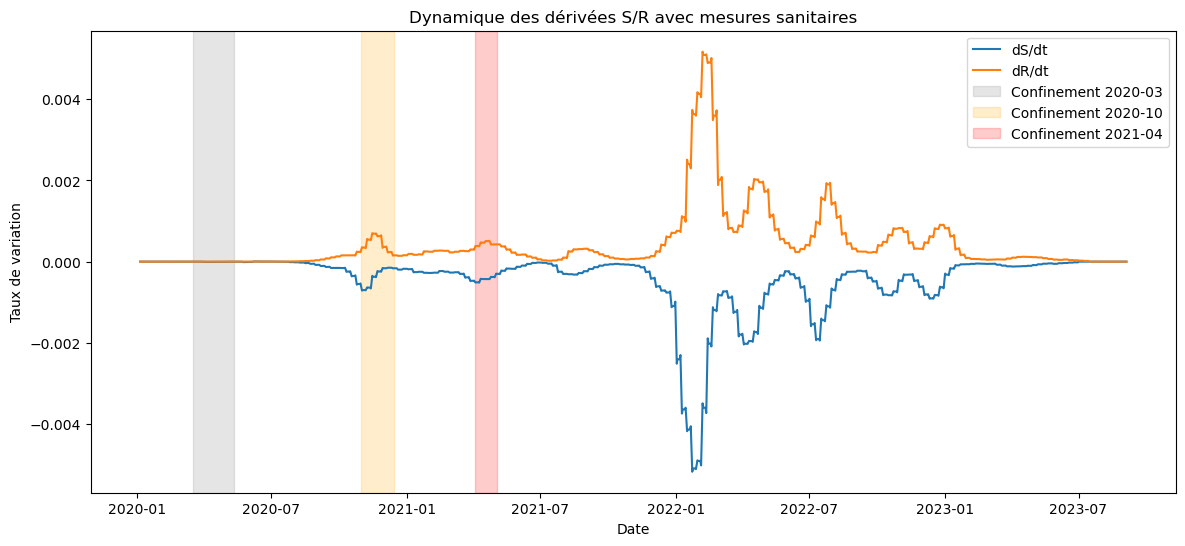

In [116]:
plt.figure(figsize=(14, 6))
plt.plot(df_fr['date'], df_fr['dS_dt'], label='dS/dt')
plt.plot(df_fr['date'], df_fr['dR_dt'], label='dR/dt')

# Ajout des périodes de confinement
confinements = [
    {'start': '2020-03-17', 'end': '2020-05-11', 'color': 'gray'},
    {'start': '2020-10-30', 'end': '2020-12-15', 'color': 'orange'},
    {'start': '2021-04-03', 'end': '2021-05-03', 'color': 'red'}
]

for c in confinements:
    plt.axvspan(pd.to_datetime(c['start']), pd.to_datetime(c['end']), 
                alpha=0.2, color=c['color'], label=f'Confinement {c["start"][:7]}')

plt.title('Dynamique des dérivées S/R avec mesures sanitaires')
plt.xlabel('Date')
plt.ylabel('Taux de variation')
plt.legend()
plt.show()